<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [8]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [9]:
# Import data

data = pd.read_csv('Data/CLEAN_REFIT_081116/CLEAN_House3.csv')
df = pd.DataFrame(data)

In [10]:
df.head()

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
0,2013-09-25 19:21:09,1380136869,387,0,0,86,0,0,0,145,0,0,0
1,2013-09-25 19:21:16,1380136876,386,0,0,86,0,0,0,144,0,0,0
2,2013-09-25 19:21:23,1380136883,383,0,0,86,0,0,0,144,0,0,0
3,2013-09-25 19:21:30,1380136890,388,0,0,87,0,0,0,145,0,0,0
4,2013-09-25 19:21:37,1380136897,388,0,0,86,0,0,0,145,0,0,0


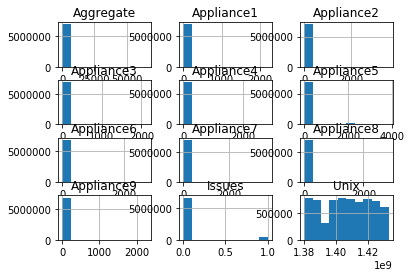

In [7]:
df.hist();